<h2>Using SAS DLPy to Create A YOLOv2 Object Detection Model</h2>


This example uses SAS DLPy to create and train a Tiny YOLOv2 object detection model. The learning objective is to understand how to use SAS DLPy and SAS CAS to subset and visualize pre-trained model data, specify a Tiny YOLOv2 model architecture, and then train the model to perform object detection. Use the trained model to make predictions on test data. Finally, generate metrics to assess the model performance.   

The example begins with configuring the computing environment. After that, the training data is prepared, which followed by training the model using pre-trained weights for a warm start. 

After training the model, a number of test images are run against the trained model and the results are visualized. Then several metrics (e.g., precision) are generated to evaluate the model performance.

<h3>Configure Your Computing Environment<a name="configureIt"></a></h3>

Begin by importing `SWAT`. SWAT is a Python interface to SAS CAS. For more information about starting a CAS session with the SWAT package, see https://sassoftware.github.io/python-swat/getting-started.html.

Next, import DLPy and the functions for the DLPy `utils`, `applications`, and `model` classes.


In [1]:
from swat import *
import dlpy
from dlpy.utils import *
from dlpy.applications import *
from dlpy.model import *
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

After configuring your environment and loading required libraries and functions, connect to your CAS server. You will need a host name and port number for this step. 

In [2]:
s = CAS(cashost, casport)

In [3]:
s.table.addcaslib(activeonadd=False,
                  datasource={'srctype':'path'},
                  name='dnfs',
                  path='/DeepLearn/bigdata',
                  subdirectories=False)

NOTE: Cloud Analytic Services added the caslib 'dnfs'.


,Name,Type,Description,Path,Definition,Subdirs,Local,Active,Personal,Hidden,Transient
0,dnfs,PATH,,/Deeplearn/bigdata/,,0.0,1.0,0.0,0.0,0.0,0.0


The output above shows caslib `dnfs` is created. The folder referenced in the `Path` column contains data for caslib tables. This step is to access some data in the server.

<h3>Preparing the Training Data<a name="subset"></a></h3>

This step accesses a large trained object detection data set saved as a `.sashdat` file, creates a smaller subset of the training data, and then saves and loads the subsetted training data as a CAS table.

Suppose your caslib data path has a file named `train_less100_yolo_416.sashdat` that contains millions of images along with their annotations. The `train_less100_yolo_416.sashdat` source table is quite large. The example creates a new, smaller training data table by subsetting the large source table. The following code filters the source data by selecting only observations that contain single-object images classified as either `Airplane` or `Vehicle`.  

In [4]:
s.loadtable('train_less100_yolo_416.sashdat', 
            caslib='dnfs', 
            casout=dict(name='trainset', replace=1), 
            where="_nObjects_ eq 1 and (_Object0_ eq 'Vehicle' or \
            (_Object0_ eq 'Airplane' and substr(idjoin,1,1) in ('a', 'b', 'c', 'd', 'e', 'f')) )")

NOTE: Cloud Analytic Services made the file train_less100_yolo_416.sashdat available as table TRAINSET in caslib CASUSER(weshiz).


[caslib]

 'CASUSER(weshiz)'

[tableName]

 'TRAINSET'

[casTable]

 CASTable('TRAINSET', caslib='CASUSER(weshiz)')

+ Elapsed: 3.48s, user: 1.28s, sys: 2.17s, mem: 15mb

<h6>Visualize Object Classes in Subsetted Training Data <a name="visualizeClasses"></a></h6>




What does the subsetted training data look like? How many instances do we have of each image class? 

To count the instances of each image class in the training data, use `simple.freq()` to generate a frequency table of the `trainset` classes across the `vars` labels for `_Object0_`, which is (`Airplane` and `Vehicle`).

In [5]:
s.simple.freq(table={'name':'trainset','vars':[{'name':'_Object0_'}]})

,Column,CharVar,FmtVar,Level,Frequency
0,_Object0_,Airplane,Airplane,1,2260.0
1,_Object0_,Vehicle,Vehicle,2,2099.0


The resulting chart shows the table `trainset` contains 4,359 images, with 2,260 objects classified as `Airplane` (about 52%) and 2,099 objects classified as `Vehicle` (about 48%).



<h3>Calculate Anchor Boxes in the Training Data<a name="anchorShapes"></a></h3>



Now, lets look at a sampling of the various anchor box shapes in the subsetted training data `trainset`.

In [6]:
yolo_anchors = get_anchors(s, data='trainset', n_anchors=5, coord_type='yolo')

The response is:

In [7]:
yolo_anchors = (9.77898381497796,
         5.595484346842886,
         2.9851300500386695,
         3.9249270317636795,
         11.5805471190956,
         11.534526021944389,
         5.183913344838019,
         8.86351514243635,
         1.0907404478357317,
         1.4339512824639398)

The output returns five groups (as n_anchors was set to 5) of anchor boxes. It is easier to visualize the anchor box shapes by grouping the output into 5 coordinate pairs:

 (9.78, 5.60) <br>
 (2.99, 3.92)<br>
 (11.58,11.54)<br>
 (5.18, 8.86) <br> 
 (1.09, 1.43) 
 
The results show a range of anchor box sizes and shapes: as small as (1.1 x 1.4) pixels, as large as (11.6 x 11.5) pixels, and rectangular as much as (9.8 x 5.6) pixels.

<h4>Define Tiny YOLOv2 Object Detection Model Architecture<a name="defineYOLO"></a></h4>

Now use DLPy to create a Tiny YOLOv2 object detection model named `yolo_model`. The model has 2 output classes (Airplane and Vehicle), and is configured to generate 5 predictions per grid in the detection layer of the model. Maximum of 100 boxes (and box labels) per image, and the table `yolo_anchors` contains the anchor shapes. 

`class_scale` sets the cost function weight for the class of object identified in the detection layer to 1. When objects exist in the grid, `coord_scale` sets the cost function weight in the detection layer to 1. If objects do not exist in the grid, `prediction_not_a_object_scale` sets cost function weight in the detection layer to 1. `object_scale` sets the cost function weight for objects identified in the detection layer to 5.

The `detection_threshold` for object detections should be set to 0.2. The `iou_threshold` (intersection over union values) for object detection is also set to 0.2.

When you use DLPy to create a `Tiny_YoloV2` model, you do not need to specify individual layers in the architecture. The DLPy API builds a Tiny YOLOv2 model using the parameter values specified in the `Tiny_YoloV2()` function.



In [8]:
yolo_model = Tiny_YoloV2(s, 
                         n_classes=2, 
                         predictions_per_grid=5, 
                         anchors = yolo_anchors,
                         max_boxes=100, 
                         coord_type='yolo',
                         max_label_per_image = 100,
                         class_scale=1.0, 
                         coord_scale=1.0, 
                         prediction_not_a_object_scale=1, 
                         object_scale=5,
                         detection_threshold=0.2, 
                         iou_threshold=0.2)

NOTE: Input layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Convolution layer added.
NOTE: Batch normalization layer added.
NOTE: Convolution layer added.
NOTE: Detection layer added.
NOTE: Model compiled successfully.


Now use `plot_network` to view a directed acyclic graph (DAG) of the Tiny YOLOv2 model `yolo_model` that you just created.

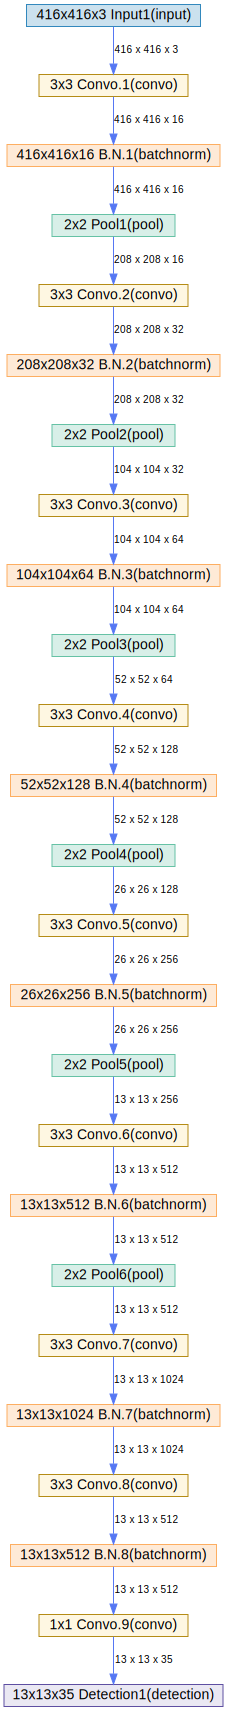

In [8]:
yolo_model.plot_network()

<h4>Load Pretrained Model Weights From .sashdat File<a name="loadWeights"></a></h4>


Training an accurate object detection model can be quite challanging. Much time can be saved by importing model weights from an already trained YOLOv2 object detection model. Suppose that you have a pre-trained set of YOLOv2 object detection model weights saved in a file named `tinyyolov2_40epoch_trainless100.sashdat`, and stored in the model directory at `/DeepLearn/bigdata`. 

The following code creates and loads a CAS table `tinyyolov2_40epoch_trainless100` in caslib `dnfs`, using the source data saved in the file `tinyyolov2_40epoch_trainless100.sashdat`. The file contains pre-trained model weights for a Tiny YOLOv2 object detection model.

Using pre-trained YOLOv2 model weights gives the example code a warm start on model optimization.

In [9]:
s.table.loadtable(casout={'name':'tinyyolov2_40epoch_trainless100','replace':True},
                  caslib='dnfs',
                  path="tinyyolov2_40epoch_trainless100.sashdat")

NOTE: Cloud Analytic Services made the file tinyyolov2_40epoch_trainless100.sashdat available as table TINYYOLOV2_40EPOCH_TRAINLESS100 in caslib CASUSER(weshiz).


[caslib]

 'CASUSER(weshiz)'

[tableName]

 'TINYYOLOV2_40EPOCH_TRAINLESS100'

[casTable]

 CASTable('TINYYOLOV2_40EPOCH_TRAINLESS100', caslib='CASUSER(weshiz)')

+ Elapsed: 0.0139s, user: 0.000793s, sys: 0.00136s, mem: 0.719mb

You can see in the above results that the CAS table `TINYYOLOV2_40EPOCH_TRAINLESS100` was created in caslib CASUSER(userID).



The following code creates a table named `targets` and a table named `inputVars`. The `targets` variable contains a list of objects along with their bounding box locations. These corresponds to the predicted object detections.

The `inputVars` variable is used to specify the image column in a CAS table.


In [10]:
targets = ['_nObjects_'];
for i in range(0,100):
    targets.append('_Object%d_'%i)
    for sp in ["x", "y", "width", "height"]:
        targets.append ('_Object%d_%s'%(i, sp))
                  
inputVars = []
inputVars.insert(0, '_image_')

<h4>Train the Tiny YOLOv2 Model Using Pre-Trained Weights<a name="trainTinyYOLO"></a></h4>


After setting `inputVars` and `targets`, train the Tiny YOLOv2 model. Use the pre-trained YOLOv2 model weights and the subsetted training data that were saved as CAS tables earlier in the example. 

Set `solver` to use a momentum solver with a learning rate of 0.001, using gradient values no smaller than -100 and no larger than 100.  Use `Optimizer()` to specify model optimization settings: solver algorithm, mini-batch size of 64, no more than 10 epochs, and perform L2 regularization using a weight of 0.005. Setting `log_level` to 2 includes epoch history in the output.

Use `DataSpec()` to associate variables with the layers. `inputVars` is for the the model input layer, and `targets` is for the model detection layer, which is the final layer. DataSpec settings are saved in the variable `data_specs`.

Use `Gpu()` to enable GPU processing for GPU0. GPU settings are saved in variable `gpu`. 

Assign the pretrained CAS table of model weights, in this case named as `tinyyolov2_40epoch_trainless100`,  to the model . 

Use `fit()` to train the model. Use the subsetted data created in CAS table `trainset` for training data. The optimizer settings are saved in `optimizer`, the data_specs settings are saved in `data_specs`, and the model should be single-threaded. Set the `record_seed` value (for random record selection within a worker) to 13309. Force equal padding in convolutional and pooling layers, and use the GPU settings saved in `gpu`. 



In [11]:
solver = MomentumSolver(learning_rate=0.001, clip_grad_max = 100, clip_grad_min = -100)
optimizer = Optimizer(algorithm=solver, mini_batch_size=64, log_level=2, max_epochs=10, reg_l2=0.005)
data_specs = [DataSpec(type_='IMAGE', layer='Input1', data=inputVars),
              DataSpec(type_='OBJECTDETECTION', layer='Detection1', data=targets)]
gpu = Gpu(devices=[0])
yolo_model.set_weights('tinyyolov2_40epoch_trainless100')
yolo_model.fit(data='trainset', 
               optimizer=optimizer, 
               data_specs=data_specs, 
               n_threads=1, 
               record_seed=13309,
               force_equal_padding=True, 
               gpu=gpu)

NOTE: Model weights attached successfully!
NOTE: Training based on existing weights.
NOTE: dlgrd009.unx.sas.com: 1 out of 4 available GPU devices are used.
NOTE:  The Synchronous mode is enabled.
NOTE:  The total number of parameters is 11031952.
NOTE:  The approximate memory cost is 301.00 MB.
NOTE:  Loading weights cost       0.32 (s).
NOTE:  Initializing each layer cost       2.74 (s).
NOTE:  The total number of threads on each worker is 1.
NOTE:  The total mini-batch size per thread on each worker is 64.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 64.
NOTE:  Epoch Learning Rate        Loss        IOU   Time(s)
NOTE:  0         0.001           13.84       0.56    25.12
NOTE:  1         0.001           6.098     0.6521    25.87
NOTE:  2         0.001           5.701     0.6654    26.10
NOTE:  3         0.001           5.196     0.6731    26.06
NOTE:  4         0.001           4.986     0.6813    24.06
NOTE:  5         0.001           4.831     0.

,Descr,Value
0,Model Name,tiny-yolov2
1,Model Type,Convolutional Neural Network
2,Number of Layers,25
3,Number of Input Layers,1
4,Number of Output Layers,0
5,Number of Convolutional Layers,9
6,Number of Pooling Layers,6
7,Number of Fully Connected Layers,0
8,Number of Batch Normalization Layers,8
9,Number of Weight Parameters,11026864


The output shows that the Tiny YOLO model was trained using pre-defined weights. The resulting model has 25 layers: 1 input layer, 9 convolutional layers, 6 pooling layers, and 8 batch normalization layers. The model has over 11 million parameters, and after 10 epochs, had a loss of 4.21 and a fit error of 0.273. 

<h4>Create Test Data and Load Test Images<a name="loadTest"></a></h4>


Now the Tiny YOLOv2 object detection model is configured and trained. We can use test data to benchmark how well the trained model performs. 

Begin by importing the DLPy `images` class. This is a specialized CASTable class for image processing.

In [12]:
from dlpy.images import *

Next, create a table `predict_tbl` and use the ImageTable function `load_files()` to populate the table with images located in `/disk/linux/dlpy/object_detection_test_data`.




In [16]:
predict_tbl = ImageTable.load_files(conn=s, path='/disk/linux/dlpy/object_detection_test_data')

Now resize all images to uniform dimensions. Use `resize()` to create 416 x 416 images. 

In [17]:
predict_tbl.resize(height=416, width=416, inplace=True)

Use `show()` to display contents of the test data image table `predict_tbl` in a grid with three columns:




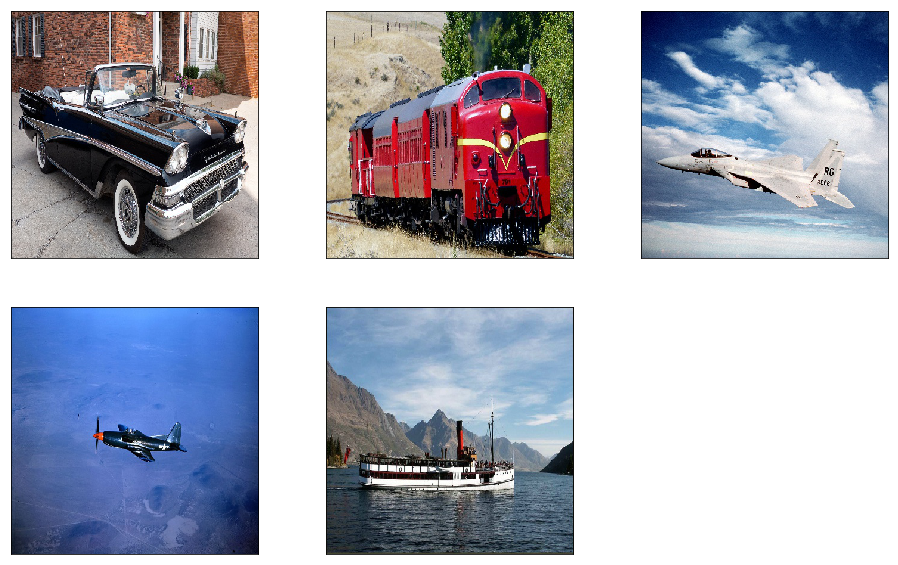

In [18]:
predict_tbl.show(ncol=3)

The test data set is small, but we clearly see images uniformly sized at 416 pixels by 416 pixels. Now we can score the test data and see how well the model performs.

<h3>Score the Test Data and Display Object Predictions<a name="scoreTest"></a></h3>


Now use `predict()` to score the images in the test data `predict_tbl`, and enable use of GPU0 during processing.

In [19]:
yolo_model.predict(data=predict_tbl, gpu = Gpu(devices=[0]))

NOTE: Due to data distribution, miniBatchSize has been limited to 1.
NOTE: Only 1 out of 2 available GPU devices are used.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read             6
 1  Number of Observations Used             0
 2     Average IOU in Detection             .

[OutputCasTables]

             casLib              Name  Rows  Columns  \
 0  CASUSER(ethem-kinginthenorth)  Valid_Res_B3esj1     6     5075   
 
                                             casTable  
 0  CASTable('Valid_Res_B3esj1', caslib='CASUSER(e...  

+ Elapsed: 2.56s, user: 1.55s, sys: 0.893s, mem: 2.06e+03mb

The output above shows an output CAS table `Valid_Res_B3esj1` containing scored image data was created.

Now, use `display_object_detections()` with `valid_res_tbl` to create a 3-column matrix of scored images, showing object detection bounding boxes with label and probability score.  

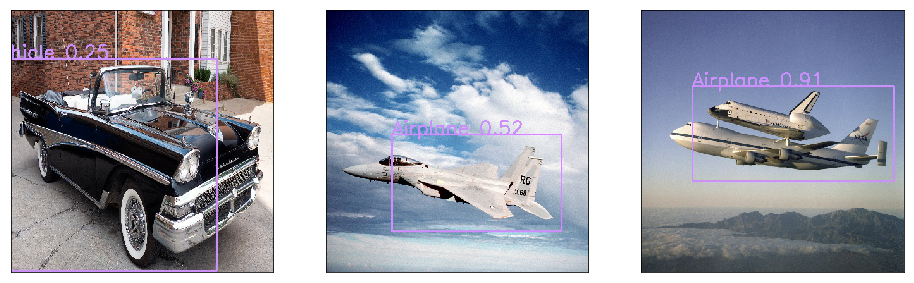

In [20]:
display_object_detections(conn=s, 
                          coord_type='yolo', 
                          max_objects=5, 
                          table=yolo_model.valid_res_tbl, 
                          num_plot=10,
                          n_col=3)

<h4>Use Model to Score A Larger Data Set <a name="scoreLarger"></a></h4>


Now evaluate the performance of the YOLOv2 object detection model by using `predict()` to detect and identify objects in the much larger training data set `trainset`. Use one GPU (GPU0) during processing. Set `buffer_size` to 1 in order to score 1 observation per batch:


In [21]:
yolo_model.predict(data='trainset', gpu=Gpu(devices=[0]), buffer_size=1)

NOTE: Only 1 out of 2 available GPU devices are used.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read          4359
 1  Number of Observations Used          4359
 2     Average IOU in Detection       0.73208
 3                   Loss Error      5.334126

[OutputCasTables]

             casLib              Name  Rows  Columns  \
 0  CASUSER(ethem-kinginthenorth)  Valid_Res_B3esj1  4359     5074   
 
                                             casTable  
 0  CASTable('Valid_Res_B3esj1', caslib='CASUSER(e...  

+ Elapsed: 7.45s, user: 108s, sys: 8.86s, mem: 2.14e+03mb

The model results show 4,359 scored observations with an average IOU (Intersection over Union) score of 0.732 and a loss of 5.334.



<h3>Generate Metrics to Evaluate Model Performance<a name="metrics"></a></h3> 


Now use `evaluate_object_detection()` with `trainset` as the ground truth table and `yolo` coordinates to evaluate prediction results for `Airplane` and `Vehicle` classes, using an `iou_thresholds` value of 0.5. 


In [22]:
metrics = yolo_model.evaluate_object_detection(ground_truth='trainset', coord_type='yolo',
                                               classes=['Airplane', 'Vehicle'], 
                                               iou_thresholds=0.5)

Evaluating class: Airplane (1210 detections)
Evaluating class: Vehicle (470 detections)


Now use `metrics` to evaluate the model performance: 


In [23]:
metrics

[{'IoU Threshold': 0.5,
  'Class Evaluation': [{'class': 'Airplane',
    'precision': array([1.        , 1.        , 1.        , ..., 0.87168874, 0.87096774,
           0.87024793]),
    'recall': array([4.42477876e-04, 8.84955752e-04, 1.32743363e-03, ...,
           4.65929204e-01, 4.65929204e-01, 4.65929204e-01]),
    'AP': 0.45299076501130014,
    'interpolated precision': array([1.        , 1.        , 0.99849398, 0.99749059, 0.98691385]),
    'interpolated recall': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    'total positives': 2260,
    'total TP': 1053.0,
    'total FP': 157.0},
   {'class': 'Vehicle',
    'precision': array([1.        , 1.        , 1.        , 1.        , 1.        ,
           1.        , 1.        , 1.        , 1.        , 1.        ,
           1.        , 1.        , 1.        , 1.        , 1.        ,
           1.        , 1.        , 1.        , 1.        , 1.        ,
           1.        , 1.        , 1.        , 1.        , 1.        ,
    

The metrics reveal that for the class `Airplane`, there were 2260 total positives (ground truth). Out of 1100 images that the model detected and classified as `Airplane`, 1053 images were correctly classified, and 157 images were incorrectly classified.

For the class `Vehicle`, there were 2099 total positives (ground truth). Out of 470 images that the model detected and classified as `Vehicle`, 323 images were correctly classified, and 147 images were incorrectly classified.